In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the images from 28x28 to 784 (matching the original format)
x_train_flattened = x_train.reshape(x_train.shape[0], -1)

# Filter for labels < 2
target_idx = np.where(y_train < 2)[0]
foreground = x_train_flattened[target_idx][:5000]/255
target_labels = y_train[target_idx][:5000]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### PCA on Regular MNIST

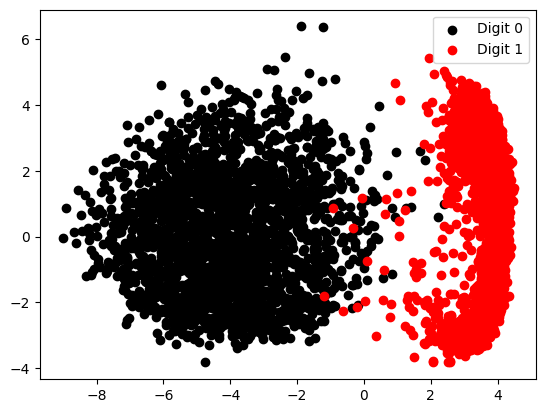

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fg = pca.fit_transform(foreground)
colors = ['k','r']

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(fg[np.where(target_labels==l),0],fg[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))
plt.legend()

# Load Natural Images of Grass

These pictures are found in this [OneDrive link](https://1drv.ms/f/s!AgLi37o1j88ahrJTLeycjuEoHpVhQw), or they can be downloaded from [ImageNet](http://image-net.org/download) using the synset 'grass'. (*Note*: replace IMAGE_PATH with path to the downloaded images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from PIL import Image

def resize_and_crop(image, size=(100, 100)):
    """
    Resizes and crops the image to the specified size.
    :param image: PIL Image
    :param size: Tuple (width, height)
    :return: Resized and cropped image
    """
    image = image.resize(size, Image.Resampling.LANCZOS)  # Resize image to 100x100
    return image

IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/ImageNet/' #Replace with your own path to downloaded images

natural_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
for filename in os.listdir(IMAGE_PATH):
  if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
    im = Image.open(os.path.join(IMAGE_PATH,filename))
    im = im.convert(mode="L") #convert to grayscale
    im = resize_and_crop(im) #resize and crop each picture to be 100px by 100px
    natural_images.append(np.reshape(im, [10000]))

natural_images=np.asarray(natural_images,dtype=float)
natural_images/=255 #rescale to be 0-1
print("Array of grass images:",natural_images.shape)

Mounted at /content/drive
Array of grass images: (1274, 10000)


# Corrupt MNIST by Superimposing Images of Grass

To create each of the 5000 corrupted digits, randomly chosen a 28px by 28px region from a grass image to be superimposed on top of the digits.

In [ ]:
np.random.seed(0) # for reproducibility

rand_indices =  np.random.permutation(natural_images.shape[0]) # just shuffles the indices
split = int(len(rand_indices)/2)
target_indices = rand_indices[0:split] # choose the first half of images to be superimposed on target
background_indices = rand_indices[split:] # choose the second half of images to be background dataset

target = np.zeros(foreground.shape)
targetplus = np.zeros(foreground.shape)
background = np.zeros(foreground.shape)

for i in range(target.shape[0]):
  idx = np.random.choice(target_indices) # randomly pick a image
  loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
  superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
  target[i] = 0.25*foreground[i] + superimposed_patch

  idx = np.random.choice(background_indices) # randomly pick a image
  loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
  background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
  background[i] = background_patch

  idx = np.random.choice(target_indices) # randomly pick a image
  loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
  superimposed_patch = np.reshape(np.reshape(natural_images[np.random.randint(natural_images.shape[0]),:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
  targetplus[i] = 0.25*foreground[i] + superimposed_patch

### Some Example Images

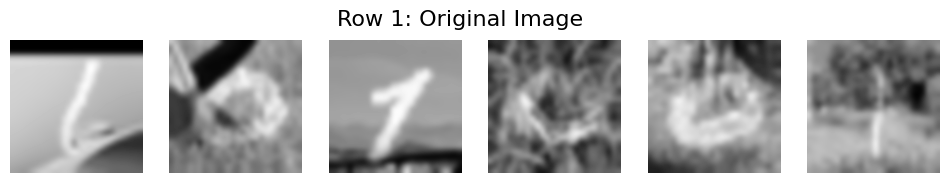

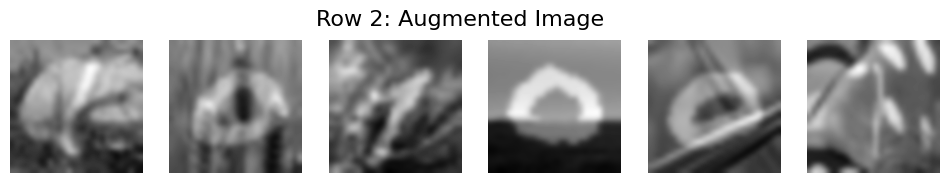

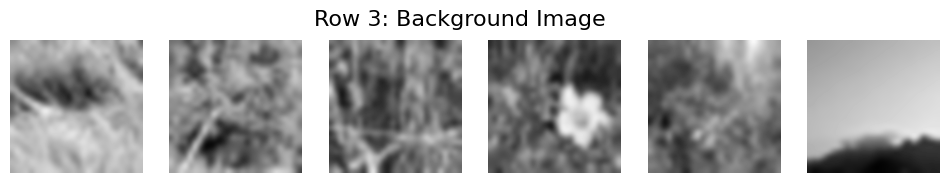

In [ ]:
n_show=6

plt.figure(figsize=[12,2])
idx = np.random.randint(0, 5000, n_show)
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    #idx=np.random.randint(5000)
    plt.imshow(np.reshape(target[idx[i],:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')
    plt.text
plt.suptitle("Row 1: Original Image", fontsize=16)
#plt.tight_layout(rect=[0, 0, 0, 0])
plt.show()

plt.figure(figsize=[12,2])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    #idx=np.random.randint(5000)
    plt.imshow(np.reshape(targetplus[idx[i],:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')
plt.suptitle("Row 2: Augmented Image", fontsize=16)
#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=[12,2])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    #idx=np.random.randint(5000)
    plt.imshow(np.reshape(background[idx[i],:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')
plt.suptitle("Row 3: Background Image", fontsize=16)
#plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### PCA on Corrupted MNIST

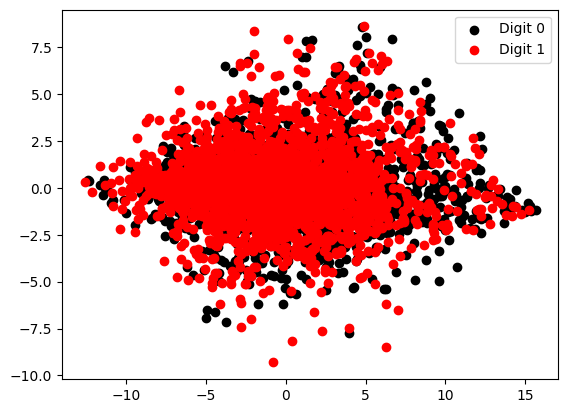

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fg = pca.fit_transform(target)

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(fg[np.where(target_labels==l),0],fg[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))
plt.legend()

# Contrastive Learning uniformity

In [ ]:
target_c = target - np.mean(target, axis= 0)
targetplus_c = targetplus - np.mean(targetplus, axis= 0)

In [ ]:
eig_vec = np.linalg.eig(target_c.T.dot(target_c)/len(target_c))[1].T[:20]
eig_val = np.linalg.eig(target_c.T.dot(target_c)/len(target_c))[0][:20]
Splus = (target_c.T.dot(targetplus_c) + targetplus_c.T.dot(target_c))/2/len(target_c)
#Splus = (target.T.dot(targetplus) + targetplus.T.dot(target))/2/len(target)
maxtrace = []
for i in range(len(eig_vec)):
  maxtrace.append(eig_vec[i].T.dot(Splus).dot(eig_vec[i])/eig_val[i])
print(maxtrace)
print('top 5', sorted(maxtrace[:20])[-5:])
print('eigvalue of X^TX:', eig_val)
print('eigvalue of Splus:', np.linalg.eig(Splus)[0][:5])
print(np.linalg.eig(foreground.T.dot(foreground)/len(foreground))[0][:20])

[np.float64(0.021852456913220027), np.float64(0.008960813589876895), np.float64(0.016065018742561176), np.float64(0.23161544060810102), np.float64(0.6208222193520926), np.float64(0.10991781813313084), np.float64(0.10009496451057993), np.float64(0.03717820658756774), np.float64(0.12980045978546423), np.float64(0.45483092276575493), np.float64(0.08064207577206424), np.float64(0.13984121692643797), np.float64(0.3614517548501004), np.float64(0.11405495890887854), np.float64(0.44092012415487986), np.float64(0.1130359784441988), np.float64(0.1380843025715319), np.float64(0.19811443826955136), np.float64(0.1559516800423213), np.float64(0.2767294103228786)]
top 5 [np.float64(0.2767294103228786), np.float64(0.3614517548501004), np.float64(0.44092012415487986), np.float64(0.45483092276575493), np.float64(0.6208222193520926)]
eigvalue of X^TX: [17.86417175  3.4237824   1.69786223  1.19491679  0.91253246  0.73595485
  0.6580469   0.5067285   0.39970704  0.37616909  0.34996582  0.31745351
  0.29910

#### Contrastive PCA

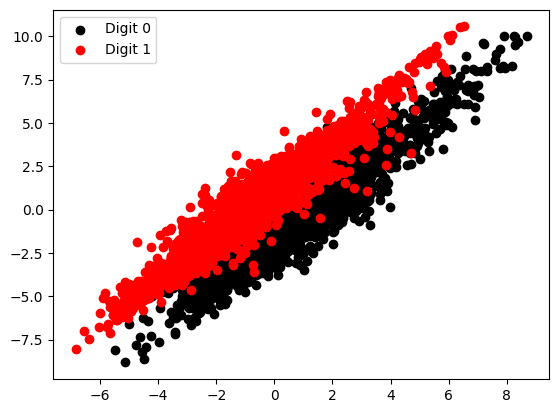

In [ ]:
#Proj_mat = eig_vec[[4, 9]]
Proj_mat = np.linalg.eig(Splus)[1].T[:2]

X_1 = target_c.dot(Proj_mat.T)
for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(X_1[np.where(target_labels==l),0],X_1[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))
plt.legend()

Contrastive PCA uniformity

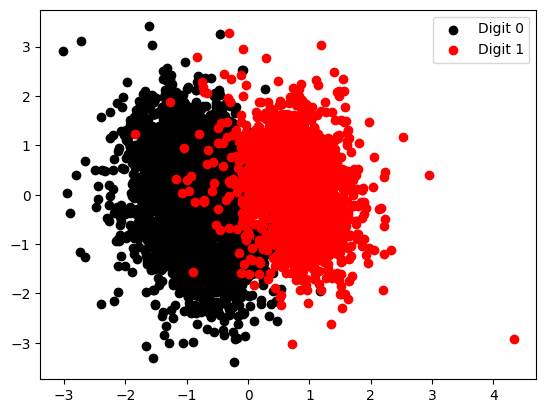

In [ ]:
# Splus = (target.T.dot(targetplus) + targetplus.T.dot(target))/2/len(target)
# S = target.T.dot(target)/len(target)
# Stotal = (target.T.dot(target) + targetplus.T.dot(targetplus))/2/len(target)

Splus = (target_c.T.dot(targetplus_c) + targetplus_c.T.dot(target_c))/2/len(target)
S = target_c.T.dot(target_c)/len(target)
Stotal = (target_c.T.dot(target_c) + targetplus_c.T.dot(targetplus_c))/2/len(target)

def Generalized_eigenvector_topk(A, B, k):
  eig_mat_B = np.linalg.eig(B)[1] #### (v_{B,1}, ...., v_{B,p})
  eig_mat_B_tild = np.dot(eig_mat_B, np.diag(np.linalg.eig(B)[0]**(-0.5)))[:,:k]
  A_tild = np.dot(eig_mat_B_tild.T, A).dot(eig_mat_B_tild)
  eig_mat_A = np.linalg.eig(A_tild)[1]
  eig_mat_A_val = np.linalg.eig(A_tild)[0]

  res = np.dot(eig_mat_B_tild, eig_mat_A)
  sorted_indices = np.argsort(eig_mat_A_val)[::-1]
  eig_mat_A_val = eig_mat_A_val[sorted_indices]
  res = res[:, sorted_indices]
  return res

Proj_mat = Generalized_eigenvector_topk(Splus, S, 30).T[:2]
X_2 = target_c.dot(Proj_mat.T)
for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(X_2[np.where(target_labels==l),0],X_2[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))
plt.legend()

PLOT

In [ ]:
# --- 2. Set Professional Plotting Style (Consistent for Both Plots) ---
# (You can define this once at the beginning of your script)
plot_params = {
    "font.family": "serif",
    "font.serif": ["Times New Roman"], # Or "Computer Modern Roman" if using LaTeX for text
    "font.size": 11, # Slightly smaller base for potentially smaller subfigures
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.figsize": (6, 5), # Adjust for a good aspect ratio for a single plot
    "axes.grid": True,
    "grid.linestyle": '--',
    "grid.alpha": 0.6,
    "savefig.dpi": 300,
    "savefig.format": 'pdf',
    "figure.autolayout": True, # Tries to prevent labels from overlapping
    "scatter.marker": "o",
}
plt.rcParams.update(plot_params)

# --- 3. Generate Plot 1: Standard Contrastive PCA ---
fig1, ax1 = plt.subplots() # Create a new figure and axes for the first plot

# # Scatter plot for Digit 0 (black)
# ax1.scatter(X_1[labels == 0, 0], X_1[labels == 0, 1],
#             color='black', label='Digit 0', alpha=0.6, s=25) # s is marker size

# # Scatter plot for Digit 1 (red)
# ax1.scatter(X_1[labels == 1, 0], X_1[labels == 1, 1],
#             color='red', label='Digit 1', alpha=0.6, s=25)

colors = ['black', 'red']
for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(X_1[np.where(target_labels==l),0],X_1[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))



ax1.set_title('Standard Contrastive PCA Embeddings')
ax1.set_xlabel('Projection onto 1st Eigenvector')
ax1.set_ylabel('Projection onto 2nd Eigenvector')
ax1.legend(loc='upper left') # Adjust legend location if needed
# ax1.set_aspect('equal', adjustable='box') # Optional: make x and y scales visually equal

# Save the first figure
file_name1 = "standard_cpca_embeddings.pdf"
plt.savefig(file_name1) # autolayout should handle bbox_inches
print(f"Plot 1 saved as {file_name1}")
#plt.close(fig1) # Close the figure to free up memory if generating many plots

# --- 4. Generate Plot 2: Truncated Constrained Contrastive PCA ---
fig2, ax2 = plt.subplots() # Create a new figure and axes for the second plot

# # Scatter plot for Digit 0 (black)
# ax2.scatter(X_2[labels == 0, 0], X_2[labels == 0, 1],
#             color='black', label='Digit 0', alpha=0.6, s=25)

# # Scatter plot for Digit 1 (red)
# ax2.scatter(X_2[labels == 1, 0], X_2[labels == 1, 1],
#             color='red', label='Digit 1', alpha=0.6, s=25)

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(X_2[np.where(target_labels==l),0],X_2[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))


ax2.set_title('Truncated Constrained cPCA (s=2)') # More concise title
ax2.set_xlabel('Projection onto 1st Eigenvector')
ax2.set_ylabel('Projection onto 2nd Eigenvector')
ax2.legend(loc='upper right') # Adjust legend location
# ax2.set_aspect('equal', adjustable='box') # Optional

# Save the second figure
file_name2 = "truncated_constrained_cpca_embeddings.pdf"
plt.savefig(file_name2)
print(f"Plot 2 saved as {file_name2}")
# plt.close(fig2) # Close the figure

# If you want to display them interactively one after another (remove plt.close):
plt.show() # after fig1 related code
plt.show() # after fig2 related code